# Género y tecnología: ¿qué eligen los estudiantes?

In [1]:
from collections import namedtuple

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import stats
import seaborn as sns
import matplotlib
import ipywidgets as widgets
from ipywidgets import interact
import folium
from folium.plugins import DualMap 
from datetime import datetime
from IPython.display import HTML, display
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs

# módulos propios
from scripts import mapas, pygal_helpers, georef, download
from scripts.pygal_helpers import df_to_pygal_line, get_pygal_html
from scripts.helpers import read_csv, format_pct, get_bins

matplotlib.style.use("ggplot")

## Evolución de género en grupo de carreras

In [2]:
df_evolucion_carreras = read_csv('grupos_evolucion_genero.csv')
df_evolucion_grupos_carreras = read_csv('grupos_carreras_evolucion_genero.csv')

df_evolucion_carreras.head(10)

,anio,carrera_grupo,estudiantes_total,estudiantes_varones,estudiantes_mujeres,nuevos_inscriptos_total,nuevos_inscriptos_varones,nuevos_inscriptos_mujeres,egresados_total,egresados_varones,egresados_mujeres,estudiantes_mujeres_pct,inscripciones_mujeres_pct,estudiantes_hombres_pct
0,2011,Arquitectura,74024.0,37663.0,36361.0,12644.0,6184.0,6460.0,3861.0,1704.0,2157.0,0.491206,0.510914,0.508794
1,2011,Arte,76792.0,29688.0,47104.0,17843.0,7270.0,10573.0,3351.0,998.0,2353.0,0.613397,0.592557,0.386603
2,2011,Deporte,3308.0,2038.0,1270.0,984.0,660.0,324.0,174.0,107.0,67.0,0.383918,0.329268,0.616082
3,2011,Derecho,241945.0,104181.0,137764.0,54097.0,24557.0,29540.0,16300.0,6926.0,9374.0,0.569402,0.546056,0.430598
4,2011,Economicas,400189.0,182896.0,217293.0,92784.0,44083.0,48701.0,25466.0,11370.0,14096.0,0.542976,0.524886,0.457024
5,2011,Educacion,56627.0,12874.0,43753.0,18042.0,4421.0,13621.0,4200.0,957.0,3243.0,0.772653,0.754961,0.227347
6,2011,Exactas,42427.0,20425.0,22002.0,8938.0,4158.0,4780.0,2511.0,1107.0,1404.0,0.518585,0.534795,0.481415
7,2011,Idiomas,19744.0,4152.0,15592.0,4397.0,946.0,3451.0,785.0,90.0,695.0,0.789708,0.784853,0.210292
8,2011,Ingenieria,104174.0,88608.0,15566.0,21540.0,17985.0,3555.0,4731.0,3907.0,824.0,0.149423,0.165042,0.850577
9,2011,Letras,370.0,68.0,302.0,102.0,24.0,78.0,11.0,0.0,11.0,0.816216,0.764706,0.183784


In [3]:
# NOTAS: Comparacion de valores absolutos de hombres y mujeres - nuevas inscripciones/ filtro por carrera (eje primaro y secundario??)

In [4]:
df_evolucion_carreras = df_evolucion_carreras[df_evolucion_carreras.anio != 2010]

In [5]:
df_evolucion_grupos_carreras = df_evolucion_grupos_carreras[df_evolucion_grupos_carreras.anio !=2010]

### ¿Cómo evolucionó la proporción de estudiantes femeninos en distintas disciplinas?

In [6]:
# gráfico de evolución hombres / mujeres por grupo de carreras

# widget: seleccionar grupo temático de carreras
variables_carreras_evolucion = tuple(df_evolucion_carreras.carrera_grupo.unique())
widget_grupos=widgets.SelectMultiple(
    options=sorted(variables_carreras_evolucion),
    value=["Tecnologia"],
    description='Areas Tematicas',
    disabled=False
)

# widget: elegir indicador
variables_indicadores_line = {
    "Ratio mujeres": "estudiantes_mujeres_pct",
    "Ratio hombres": "estudiantes_hombres_pct"
}
widget_indicador = widgets.ToggleButtons(
    options=variables_indicadores_line.items(),
    description="Indicador : ",
    value="estudiantes_mujeres_pct"
)

@interact(carrera_grupo=widget_grupos, indicador=widget_indicador)
def generate_chart_evolucion_grupos(carrera_grupo, indicador):
    
    serie_grupo_carrera = df_evolucion_carreras[
        df_evolucion_carreras.carrera_grupo.isin(carrera_grupo)][[
            "anio", 'carrera_grupo',  indicador]]

    serie_grupo_carrera[indicador]=serie_grupo_carrera[indicador].apply(format_pct)
    
    df_pivot_serie_grupo_carrera = serie_grupo_carrera.pivot_table(
        index='anio', columns='carrera_grupo', values=indicador)
    
    return HTML(get_pygal_html(df_to_pygal_line(df_pivot_serie_grupo_carrera)))
        
#NOTAS: aclarar en nota que los valores son porcentajes

interactive(children=(SelectMultiple(description='Areas Tematicas', index=(17,), options=('Arquitectura', 'Art…

In [7]:
# gráfico de evolución de las carreras dentro de un grupo

@interact(carrera_grupo=widget_grupos) #widget diferente
def generate_chart_evolucion_titulos(carrera_grupo):
    
    serie_grupo_carrera = df_evolucion_grupos_carreras[
        df_evolucion_grupos_carreras.carrera_grupo.isin(carrera_grupo)][[
        "anio", 'carrera_nombre',  "estudiantes_mujeres_pct"]]
    df_pivot_serie_grupo_carrera = serie_grupo_carrera.pivot_table(
        index='anio', columns='carrera_nombre', values='estudiantes_mujeres_pct')
    
    return HTML(get_pygal_html(df_to_pygal_line(df_pivot_serie_grupo_carrera)))
        

interactive(children=(SelectMultiple(description='Areas Tematicas', index=(17,), options=('Arquitectura', 'Art…

In [8]:
#agregar mas de un filtro para ir comparando
#modificar en ETL abogacia y derecho
#apertura por carreras para entender donde hace el pico y decrecimiento tech - cambiar pKEY por carrera y grupo carrera - grafico exploratorio
#segunda tabla de ETL donde haya grupo carrera (carrera) + universidades
#grafico con valores absolutos - apilados o algo que represente orden de magnitud año por default 

## Comparación de género por provincias y universidades

In [9]:
df_universidades = pd.read_csv('data/output/universidades_mapa.csv')
df_evolucion_ubicacion = pd.read_csv('data/output/ubicacion_evolucion_genero.csv', 
                                     dtype={'provincia_id': str})
df_evolucion_ubicacion['provincia_id'] = df_evolucion_ubicacion.provincia_id.str.zfill(2)

In [10]:
argentina_coords = [-40, -64]
osm_no_labels = "https://tiles.wmflabs.org/osm-no-labels/{z}/{x}/{y}.png"
ign_labels = "http://wms.ign.gob.ar/geoserver/gwc/service/tms/1.0.0/capabaseargenmap@EPSG%3A3857@png/{z}/{x}/{y}.png"

## Indicadores por provincia

In [11]:
INDICADORES_HEATMAP = {
    "estudiantes_mujeres_pct" : "Ratio de estudiantes mujeres",
    "estudiantes_grupo_pct" : "Ratio de estudiantes",
    "estudiantes_varones" : "Total de estudiantes hombres",
    #"estudiantes_mujeres" : "Total de estudiantes mujeres", 
    #"inscriptos_mujeres_pct" : "Ratio de inscriptas mujeres ",
    #"inscriptos_hombres_pct" : "Ratio de inscriptas hombres ",
    #"estudiantes_hombres_pct" : "Ratio de estudiantes hombres ",
}
variables_indicadores = {
    "Ratio mujeres": "estudiantes_mujeres_pct",
    "Ratio grupo": "estudiantes_grupo_pct",
    "Est. hombres": "estudiantes_varones"
}

variables_carreras_heatmap = sorted(df_evolucion_ubicacion.carrera_grupo.unique())
variables_anio_heatmap = sorted(df_evolucion_ubicacion.anio.unique())

widget_indicador = widgets.ToggleButtons(
    options=variables_indicadores.items(),
    description="Indicador : ",
    value="estudiantes_mujeres_pct"
)

widget_carreras = widgets.Dropdown(
    options=variables_carreras_heatmap,
    description="Grupo : ",
    value="Tecnologia"
)

widget_anio = widgets.Dropdown(
    options=variables_anio_heatmap,
    description="Año : ",
    value=2016
)

widget_scale = widgets.RadioButtons(
    options=['Cuantiles', 'Fija', 'Relativa'],
    description='Escala :',
    value='Relativa'
)

@interact(anio=widget_anio,
          carrera_grupo=widget_carreras,
          indicador=widget_indicador,
          scale_type=widget_scale
         )
def generate_heat_map(anio, carrera_grupo, indicador, scale_type=None):
    mapa_heatmap = folium.Map(location=argentina_coords, zoom_start=4)
    folium.TileLayer(ign_labels, tms=True, attr="IGN").add_to(mapa_heatmap)
    
    df_filter = df_evolucion_ubicacion[(df_evolucion_ubicacion.anio == anio)&
                           (df_evolucion_ubicacion.carrera_grupo == carrera_grupo)]
    
    if scale_type == 'Cuantiles':
        bins = list(df_filter[indicador].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))
    elif scale_type == 'Fija':
        bins = get_bins(df_evolucion_ubicacion[indicador].min(), df_evolucion_ubicacion[indicador].max())
    else:
        bins = 5
       
    indicador_desc = INDICADORES_HEATMAP[indicador]
    folium.Choropleth(
        geo_data="data/input/provincias.geojson", # la capa de provincias en GeoJson
        data=df_filter, # DataFrame con los datos a graficar
        columns=['provincia_id', indicador], # columna con id de geometrías, columna con el dato
        key_on='feature.properties.id', # campo del geojson que tiene el id de las geometrías
        fill_color='YlGn', # escala de colores a usar
        #fill_opacity=0.7, # opacidad del color de relleno
        #line_opacity=0.2, # opacidad de las líneas que separan los polígonos
        legend_name='{} en {} (Año {})'.format(indicador_desc, carrera_grupo, anio), # título de la leyenda de la escala
        bins=bins
    ).add_to(mapa_heatmap)
    #mapas.add_labels_from_column(mapa_heatmap,df_evolucion_ubicacion,"nombre")

    return mapa_heatmap

# NOTAS
#Agregar un tooltip que muestre informacion de la provincia al pasar el cursor. Nombre provincia, estudiantes totales, año, porcentaje de mujeres, cantidad de universidades por provincia.
#Hacer zoom sobre la cuidad de buenos aires. Hacer un grafico nuevo
#min, max y media de la variable analizada por grupo.
#Agregar grafico de evolucion y/y entre provincias por grupo de carreras. Grafico de barras con la composicion de los grupos
#Cambiar los nombres a los indices porque son muy tecnicos. Podriamos usar indice de feminidad, grupo??, masculidad
#Se puede cambiar la escala cuando no hay datos?? (blancos o transparente)
#Tabla con visualizacon y que tenga un orden de ranking para poder identificar facilmente cual es la provincia que mas avanzo

interactive(children=(Dropdown(description='Año : ', index=5, options=(2011, 2012, 2013, 2014, 2015, 2016, 201…

## Indicadores por universidad

In [12]:
def mapear_universidades(mapa, df, 
                         lat_col, lon_col, institucion_nombre_col, 
                         estudiantes_total_col, estudiantes_mujeres_pct_col, carreras_grupos_col):
    """ cargar informacion al marker de forma masiva.

        Args:
            lat (float): latitud
            lon (float): longuitud
            institucion_nombre (str): nombre de la universidad
            carreras_grupos (list): lista con las areas de estudios ofrecidas

        """
    
    for row in df.iterrows():
        mapas.crear_marker(
            mapa,
            row[1][lat_col],
            row[1][lon_col],
            row[1][institucion_nombre_col],
            row[1][estudiantes_total_col],
            row[1][estudiantes_mujeres_pct_col],
            str(row[1][carreras_grupos_col]).split(",")
        )
        
#NOTAS: agregar feminidad por grupo carrera, elegir si queremos hacer selector por año o elegir 2016.    

In [13]:
mapa_markers = folium.Map(location=argentina_coords, zoom_start=4)
folium.TileLayer(ign_labels, tms=True, attr="IGN").add_to(mapa_markers)

In [14]:
%pdb

Automatic pdb calling has been turned ON


In [15]:
mapear_universidades(
    mapa_markers, df_universidades, 
    "lat","lon","institucion_nombre", 
    "estudiantes_total", "estudiantes_mujeres_pct",
    "carrera_grupo_indics"
)

In [16]:
folium.Popup()

In [17]:
mapa_markers

# NOTAS
#Mapa + tabla "donde estudio" puedo hacer un filtro por grupo carrera (inverso a lo que estamos haciendo) 
#Cantidad de alumnas mujeres o comparacion de universidades
#agregar al tooltip el indice de feminidad

## Indicadores por universidad Y heatmap

In [18]:
def generate_heat_marker_map(anio, carrera_grupo, indicador, scale_type=None):
    mapa = folium.Map(location=argentina_coords, zoom_start=4)
    folium.TileLayer(ign_labels, tms=True, attr="IGN").add_to(mapa)
    
    df_filter = df_evolucion_ubicacion[(df_evolucion_ubicacion.anio == anio)&
                           (df_evolucion_ubicacion.carrera_grupo == carrera_grupo)]
    
    if scale_type == 'Cuantiles':
        bins = list(df_filter[indicador].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))
    elif scale_type == 'Fija':
        bins = get_bins(df_evolucion_ubicacion[indicador].min(), df_evolucion_ubicacion[indicador].max())
    else:
        bins = 5
       
    indicador_desc = INDICADORES_HEATMAP[indicador]
    folium.Choropleth(
        geo_data="data/input/provincias.geojson", # la capa de provincias en GeoJson
        data=df_filter, # DataFrame con los datos a graficar
        columns=['provincia_id', indicador], # columna con id de geometrías, columna con el dato
        key_on='feature.properties.id', # campo del geojson que tiene el id de las geometrías
        fill_color='YlGn', # escala de colores a usar
        #fill_opacity=0.7, # opacidad del color de relleno
        #line_opacity=0.2, # opacidad de las líneas que separan los polígonos
        legend_name='{} en {} (Año {})'.format(indicador_desc, carrera_grupo, anio), # título de la leyenda de la escala
        bins=bins
    ).add_to(mapa)
    #mapas.add_labels_from_column(mapa_heatmap,df_evolucion_ubicacion,"nombre")
    
    mapear_universidades(
        mapa, df_universidades, 
        "lat","lon","institucion_nombre",
        "estudiantes_total",
        "estudiantes_mujeres_pct",
        "carrera_grupo_indics",
    )

    return mapa

In [19]:
generate_heat_marker_map(2016, 'Tecnologia', 'estudiantes_mujeres_pct')

## Relación entre % de mujeres en tecnología y % de mujeres en general

In [20]:
df_universidades

,universidad_nombre,institucion_nombre,institucion_direccion,api,coordenadas,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,estudiantes_varones,estudiantes_mujeres,nuevos_inscriptos_total,nuevos_inscriptos_varones,nuevos_inscriptos_mujeres,egresados_total,egresados_varones,egresados_mujeres,estudiantes_mujeres_pct,estudiantes_mujeres_tec_pct
0,Escuela Universitaria de Teologia,Escuela Universitaria de Teologia,Pasaje Catedral 1750,NaN,"-36.4494181,-57.7686044",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Facultad Latinoamericana de Ciencias Sociales,Facultad Latinoamericana de Ciencias Sociales,Tucumán 1966,NaN,"-34.6021735,-58.3972997",NaN,NaN,NaN,NaN,NaN,...,715.0,1706.0,925.0,269.0,656.0,303.0,73.0,230.0,0.704667,NaN
2,Instituto Universitario CEMIC,Instituto Universitario CEMIC,Valdenegro 4337,NaN,"-34.5547176,-58.4972877",NaN,NaN,NaN,NaN,NaN,...,208.0,543.0,265.0,76.0,189.0,75.0,16.0,59.0,0.723036,NaN
3,Instituto Universitario de Gendarmeria Nacional,Instituto Universitario de Gendarmeria Nacional,Av. Paseo Colón 533,NaN,"-34.6142528,-58.371724",NaN,NaN,NaN,NaN,NaN,...,1189.0,366.0,319.0,259.0,60.0,258.0,185.0,73.0,0.235370,0.191781
4,Instituto Universitario Escuela Argentina de N...,Instituto Universitario Escuela Argentina de N...,Av. Córdoba 1690,NaN,"-34.5997447,-58.3934405",NaN,NaN,NaN,NaN,NaN,...,699.0,827.0,575.0,257.0,318.0,180.0,99.0,81.0,0.541940,0.233333
5,Instituto Universitario Escuela de Medicina de...,Instituto Universitario Escuela de Medicina de...,Potosí 4265,NaN,"-34.6071979,-58.4291149",NaN,NaN,NaN,NaN,NaN,...,322.0,706.0,363.0,97.0,266.0,111.0,27.0,84.0,0.686770,0.342105
6,Instituto Universitario Italiano de Rosario,Instituto Universitario Italiano de Rosario,Crespo 843,NaN,"-32.9415838,-60.6705633",NaN,NaN,NaN,NaN,NaN,...,481.0,887.0,318.0,97.0,221.0,162.0,45.0,117.0,0.648392,NaN
7,Universidad Favaloro,Universidad Favaloro,Av. Entre Ríos 495,NaN,"-34.6148113,-58.3940258",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Universidad Abierta Interamericana,Universidad Abierta Interamericana,Av. San Juan 951,http://apis.datos.gob.ar/georef/api/direccione...,"-34.6221199173329, -58.379325181549746",NaN,NaN,NaN,NaN,NaN,...,9574.0,11488.0,5129.0,2231.0,2898.0,3405.0,1560.0,1845.0,0.545437,0.104733
9,Universidad Adventista del Plata,Universidad Adventista del Plata,25 de mayo 99,http://apis.datos.gob.ar/georef/api/direccione...,"-32.0759594,-60.4665987",NaN,NaN,NaN,NaN,NaN,...,1522.0,1633.0,574.0,312.0,262.0,259.0,91.0,168.0,0.517591,0.103175


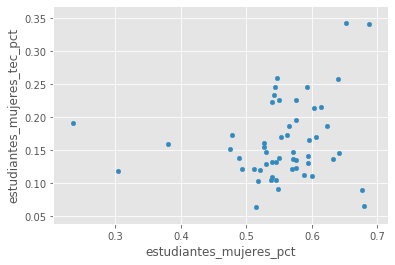

In [21]:
df_universidades.plot(kind="scatter", 
                      x="estudiantes_mujeres_pct", 
                      y="estudiantes_mujeres_tec_pct")

## Grupos de carreras por su % de femineidad

In [22]:
carreras_mujeres_pct = df_evolucion_grupos_carreras[df_evolucion_grupos_carreras.anio == 2017][
    ["carrera_grupo", "carrera_nombre", "estudiantes_mujeres_pct"]
].dropna()
carreras_mujeres_pct.head()

,carrera_grupo,carrera_nombre,estudiantes_mujeres_pct
1930,Arquitectura,Arquitectura y Urbanismo,0.507336
1931,Arquitectura,Construcciones,0.197239
1932,Arquitectura,Diseño Industrial,0.434535
1933,Arquitectura,Diseño de Interiores,0.829090
1934,Arquitectura,Ingenieria Naval,0.142857


In [23]:
X = carreras_mujeres_pct[["estudiantes_mujeres_pct"]].dropna().values
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)

In [24]:
carreras_mujeres_pct["cluster"] = pred_y

In [25]:
carreras_mujeres_pct.groupby("cluster").mean()

,estudiantes_mujeres_pct
cluster,
0,0.216648
1,0.785744
2,0.533427


In [26]:
carreras_mujeres_pct[carreras_mujeres_pct.cluster == 0]

,carrera_grupo,carrera_nombre,estudiantes_mujeres_pct,cluster
1931,Arquitectura,Construcciones,0.197239,0
1934,Arquitectura,Ingenieria Naval,0.142857,0
1935,Arquitectura,Ingenieria Vial,0.179487,0
1947,Arte,Ingenieria Forestal e Industrias de la Madera,0.196429,0
1949,Arte,Musica,0.359244,0
1952,Deporte,Actividad Fisica y Deportes,0.371762,0
1955,Deporte,Periodismo,0.233780,0
1958,Derecho,Ciencia Politica,0.322581,0
1961,Derecho,Criminologia,0.000000,0
1976,Economicas,Administracion y Gestion Ambiental,0.326531,0
